In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn
import numpy as np
from torch import optim

In [2]:
class CustomSGD:
    def __init__(self, params, lr=0.01, momentum=0.9):
        """
        Custom optimizer using NumPy for computations.

        :param params: Iterable of PyTorch parameters
        :param lr: Learning rate
        :param momentum: Momentum factor
        """
        self.params = []
        for p in params:
            param_data = p.data.numpy()  # Convert the parameter tensor to a NumPy array
            param_grad_placeholder = np.zeros_like(param_data)  # Initialize a corresponding zero array
            momentum_placeholder = np.zeros_like(param_data)  # Initialize momentum array
            self.params.append((p, param_grad_placeholder, momentum_placeholder))  # Append the parameter, gradient, and momentum placeholders
        self.lr = lr
        self.momentum = momentum

    def step(self):
        """
        Perform a single optimization step.
        """
        for (param, _, momentum_placeholder) in self.params:
            if param.grad is not None:
                grad_np = param.grad.data.numpy()  # Convert gradient to NumPy array
                momentum_update = self.momentum * momentum_placeholder - self.lr * grad_np
                param.data = torch.from_numpy(param.data.numpy() + momentum_update)  # Convert back to PyTorch tensor
                momentum_placeholder[:] = momentum_update  # Update momentum placeholder

    def zero_grad(self):
        """
        Zero the gradients of all optimized parameters.
        """
        for (param, _, _) in self.params:
            if param.grad is not None:
                grad_shape = param.grad.data.numpy().shape
                param.grad = torch.from_numpy(np.zeros(grad_shape, dtype=np.float32))

In [3]:
# does not yield good results within 15 epochs
class CustomRMS:
    def __init__(self, params, lr=0.001, alpha=0.99, eps=1e-08):
        """
        Custom optimizer using NumPy for computations.
        """
        # Store each parameter and its corresponding squared gradient average
        self.params = [(p, np.zeros_like(p.data.numpy())) for p in params]
        self.lr = lr
        self.alpha = alpha
        self.eps = eps

    def step(self):
        """
        Perform a single optimization step (parameter update).
        """
        for (param, square_avg) in self.params:
            if param.grad is not None:
                grad_np = param.grad.data.numpy()  # Convert gradient to NumPy array
                # Update squared average using NumPy operations
                square_avg = self.alpha * square_avg + (1 - self.alpha) * np.square(grad_np)
                # Compute standard deviation and perform parameter update
                std = np.sqrt(square_avg) + self.eps
                update = -self.lr * grad_np / std
                param.data = torch.from_numpy(param.data.numpy() + update)  # Convert back to PyTorch tensor

    def zero_grad(self):
        """
        Zero the gradients of all optimized parameters.
        """
        for (param, _) in self.params:
            if param.grad is not None:
                # Manually zero the gradients using NumPy
                grad_shape = param.grad.data.numpy().shape
                param.grad = torch.from_numpy(np.zeros(grad_shape, dtype=np.float32))

In [4]:
# MNIST Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('dataset/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('dataset/test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [5]:
# Model definition
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]), nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size), nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
# optimizer = CustomRMS(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08)
# optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
optimizer =  CustomSGD(model.parameters(), lr=0.01, momentum=0.9)

In [6]:
# Training Loop
epochs = 15
training_losses = []
validation_accuracies = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        training_loss = running_loss / len(trainloader)
        training_losses.append(training_loss)

        # Validation accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        validation_accuracy = correct / total
        validation_accuracies.append(validation_accuracy)
        print(f"Epoch {e+1} - Training Loss: {training_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")


Epoch 1 - Training Loss: 0.4251, Validation Accuracy: 0.9374
Epoch 2 - Training Loss: 0.1819, Validation Accuracy: 0.9559
Epoch 3 - Training Loss: 0.1320, Validation Accuracy: 0.9609
Epoch 4 - Training Loss: 0.1050, Validation Accuracy: 0.9608
Epoch 5 - Training Loss: 0.0896, Validation Accuracy: 0.9604
Epoch 6 - Training Loss: 0.0783, Validation Accuracy: 0.9598
Epoch 7 - Training Loss: 0.0682, Validation Accuracy: 0.9722
Epoch 8 - Training Loss: 0.0627, Validation Accuracy: 0.9748
Epoch 9 - Training Loss: 0.0559, Validation Accuracy: 0.9691
Epoch 10 - Training Loss: 0.0501, Validation Accuracy: 0.9771
Epoch 11 - Training Loss: 0.0450, Validation Accuracy: 0.9753
Epoch 12 - Training Loss: 0.0398, Validation Accuracy: 0.9764
Epoch 13 - Training Loss: 0.0368, Validation Accuracy: 0.9731
Epoch 14 - Training Loss: 0.0330, Validation Accuracy: 0.9779
Epoch 15 - Training Loss: 0.0290, Validation Accuracy: 0.9798


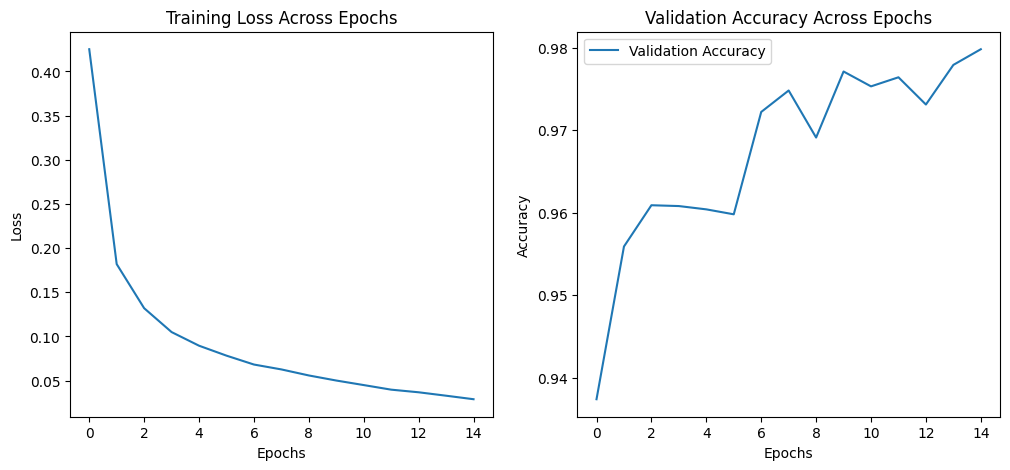

In [7]:
# Plotting Training Loss and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs')

plt.subplot(1, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Epochs')
plt.legend()
plt.show()